In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from portfolio import Portfolio
%matplotlib inline 

## read in data
ret_df_raw= pd.read_excel( io= 'Data/cipc data.xlsx', sheetname= 'Data_Input', index_col=0)

ret_df= ret_df_raw[['US_RE', 
                   'US_PE',
                   'US_CORP',
                   'SP500',
                   'Rusell2000',
                   'EAFE',
                   'EM']]
                   #'USGOVT10Y']]
ret_df_cov= ret_df.cov()

UniverseProperty= {}

from sklearn.covariance import LedoitWolf
LW= LedoitWolf( ).fit(ret_df)
LW_alpha= LW.shrinkage_

LW_cov= pd.DataFrame(LW.covariance_)*4
LW_cov.index= ret_df_cov.index
LW_cov.columns= ret_df_cov.columns
LW_vol= np.sqrt(np.diag(LW_cov))
LW_corr= pd.DataFrame( np.dot( np.dot( np.diag(1/ LW_vol), LW_cov), np.diag(1/LW_vol)) , 
                      index= LW_cov.index, columns= LW_cov.columns)
CMA_passive_geo= np.array( [7, 8.8, 2.75, 7.21, 8.06, 7.07, 8.03 ])/100
CMA_active_geo= CMA_passive_geo+ np.array( [0,0, 0.5, 1,1,1,1])/100
CMA_passive_arith= CMA_passive_geo+ 0.5* LW_vol**2
LW_cov_active= LW_cov+ np.diag([0, 0, 4, 9,9,9,9])/10000
LW_vol_active= np.sqrt(np.diag(LW_cov_active))
CMA_active_arith= CMA_active_geo+ 0.5* LW_vol_active**2

# the asset universe properties
UniverseProperty['asset_name']= LW_cov.index.tolist()
UniverseProperty['asset_count']= LW_cov.shape[0]
UniverseProperty['LW_cov']= LW_cov
UniverseProperty['LW_vol']= LW_vol
UniverseProperty['LW_corr']= LW_corr
UniverseProperty['CMA_active_geo']= CMA_active_geo
UniverseProperty['CMA_active_arith']= CMA_active_arith
UniverseProperty['LW_cov_active']= LW_cov_active
UniverseProperty['LW_vol_active']= LW_vol_active


# Portfolios

portfolios= {}
portfolios['EqualWeights']= Portfolio(asset_ret= UniverseProperty['CMA_active_geo'], 
                                      asset_cov= UniverseProperty['LW_cov_active'], 
                                      weight= [1/UniverseProperty['asset_count']]* UniverseProperty['asset_count'])

tmp= np.array([0.14,0.29,0.05,0.24,0.03,0.21,0.05])
tmp= tmp/ np.sum(tmp)
portfolios['Peer']= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                             asset_cov= UniverseProperty['LW_cov_active'], 
                             weight= tmp)


# solve ERC

def temp_ERC_func(w, sigma):
    A= np.diag( w)
    B= np.diag( np.dot( sigma, w))
    C= np.diag( np.dot( A, B))/ np.dot( np.dot( w, sigma), w)- np.ones( w.size )* 1/ w.size
    return np.dot( C, C)

from scipy.optimize import minimize 

ERC_opt_res= minimize( temp_ERC_func, 
                 x0= portfolios['EqualWeights'].weight ,
                 args= LW_cov,
                 method= 'Powell',
                 options= {'disp': True},
                 tol= 1e-16)

weight_erc = ERC_opt_res.x/ np.sum( ERC_opt_res.x)

# ERC portfolio
portfolios['ERC']= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                            asset_cov= UniverseProperty['LW_cov_active'],
                            weight= weight_erc)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 1281




## Frontier Construction 


In [2]:

def frontier_obj(w, sigma):
    return (np.dot(  np.dot( w, sigma), w)* .5)

def frontier_obj_der( w, sigma): 
    return (np.dot( w, sigma))


frontier_cons0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*w.size)}

frontier_uncons={}

for target_ret in np.linspace(0.045, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    
    # unconstrained opt
    MV_opt_1= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0, None]]* UniverseProperty['asset_count'],
                    tol= 1e-10)  # long only constrain
    
    frontier_uncons[target_ret]= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                                         asset_cov= UniverseProperty['LW_cov_active'],
                                         weight= MV_opt_1.x)
    




Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
    

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]



            Current function value: 0.001574867831277577
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001594843332984004
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0016163912437925409
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0016395115740838904
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001664204292715945
            Iterations: 19
            Function evaluations: 19
            Gradient eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0037692433490048812
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0038519000321678943
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003935984620579595
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004021495793959856
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004108433644148469
            Iterations: 29
       

In [3]:
frontier_uncons_NoCorp={}



for target_ret in np.linspace(0.07, 0.1, 100): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    # unconstrained opt
    MV_opt_2= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0, None], [0, None], [0, 1e-15]]+ [[0, None]]* ( UniverseProperty['asset_count']- 3),
                    tol= 1e-8)  # long only constrain
    
    frontier_uncons_NoCorp[target_ret]= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                                         asset_cov= UniverseProperty['LW_cov_active'],
                                         weight= MV_opt_2.x)
    




Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Fu

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
          

            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0047662138075351464
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004821581104259152
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004878810410399419
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00493791269645381
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004998804977243388

In [4]:
frontier_cons= {}

for target_ret in np.linspace(0.06, 0.08, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    MV_opt_3= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0,0.3]]* UniverseProperty['asset_count'],
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_cons[target_ret]=   Portfolio( asset_ret= UniverseProperty['CMA_active_geo'], 
                                        asset_cov= UniverseProperty['LW_cov_active'],
                                        weight= MV_opt_3.x)
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
    

            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient e

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003276797857876091
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0033060915179760836
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0033356360454599534
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0033654314404206504
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0033954777028252993
            Iterations: 24
     

In [5]:
frontier_cons_NoCorp= {}

for target_ret in np.linspace(0.07, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    MV_opt_4= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0,0.3], [0, 0.3], [0, 1e-15]]+ [[0, 0.3]]* ( UniverseProperty['asset_count']-3) ,
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_cons_NoCorp[target_ret]=   Portfolio( asset_ret= UniverseProperty['CMA_active_geo'], 
                                        asset_cov= UniverseProperty['LW_cov_active'],
                                        weight= MV_opt_4.x)
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
         

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
         

            Current function value: 0.007287369182719972
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007385008719090219
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007485643102775511
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007589272333775845
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007695896412091239
            Iterations: 19
            Function evaluations: 19
            Gradient evalua

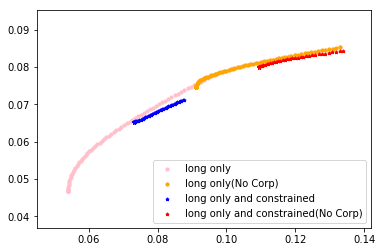

In [6]:
fig= plt.figure()

frontier_uncons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_uncons.values()]
frontier_uncons_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_uncons_pair], y= [x[0] for x in frontier_uncons_pair], 
            marker='o', c= 'pink', s=10, label= 'long only')

frontier_uncons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_uncons_NoCorp.values()]
frontier_uncons_NoCorp_pair.sort(key= lambda x : x[0])
plt.scatter( x= [x[1] for x in frontier_uncons_NoCorp_pair], y = [x[0] for x in frontier_uncons_NoCorp_pair], 
           marker= 'o', c= 'orange', s=10, label= 'long only(No Corp)')


frontier_cons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_cons.values()]
frontier_cons_pair.sort(key= lambda x : x[0])
plt.scatter(x= [x[1] for x in frontier_cons_pair], y= [x[0] for x in frontier_cons_pair], 
            marker= '*', c= 'blue' , s=10, label= 'long only and constrained')

frontier_cons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_cons_NoCorp.values()]
frontier_cons_NoCorp_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_cons_NoCorp_pair], y= [x[0] for x in frontier_cons_NoCorp_pair], 
           marker= '*', c= 'red', s=10, label= 'long only and constrained(No Corp)')
plt.legend()

## Peer Implied Return 


In [7]:
risk_free= 179/10000
gamma= 3.5

UniverseProperty['impliedExpectedReturn_peer_arith']= portfolios['Peer'].implied_ExpectedReturn(gamma= gamma, risk_free= risk_free)
UniverseProperty['impliedExpectedReturn_peer_geo']= UniverseProperty['impliedExpectedReturn_peer_arith']- .5* np.diag(UniverseProperty['LW_cov'])

UniverseProperty['impliedExpectedReturn_peer_geo']

array([ 0.03096314,  0.05941507,  0.01987301,  0.06643129,  0.07014947,
        0.07036907,  0.0680927 ])

In [8]:
np.array(UniverseProperty['impliedExpectedReturn_peer_arith'] )

array([ 0.0359304 ,  0.06939446,  0.02185507,  0.07806678,  0.0895547 ,
        0.08693194,  0.10000493])

## Combined Return (BL) and Frontier 


In [9]:
from blacklitterman import naive_BlackLitterman

In [10]:
#Apply BL to arithmatic expected return 

prior_ExpectedReturn= UniverseProperty['impliedExpectedReturn_peer_arith']
prior_cov= UniverseProperty['LW_cov_active']
tau= 0.05
prior_risk= UniverseProperty['LW_cov']* tau

views_weight= np.identity(UniverseProperty['asset_count'])
views_expectedReturn= UniverseProperty['CMA_active_arith']
views_risk = UniverseProperty['LW_cov_active']* 2*tau


arithBL= naive_BlackLitterman( prior_ExpectedReturn= prior_ExpectedReturn, prior_uncertainty= prior_risk, prior_cov= prior_cov, 
                         views_weight= views_weight, views_return= views_expectedReturn, views_uncertainty= views_risk)

UniverseProperty['arithBL_peer_CMAactive']= arithBL
# Note: the prior, view and post are arithmatic 
# To convert the aithmatic post expected return to geometric, deduct half post return variance. 


In [11]:
arithBL.post_ExpectedReturn- .5* np.diag( arithBL.post_cov) # post geometric expected return 

array([ 0.04380985,  0.06861074,  0.02357064,  0.07104906,  0.07605534,
        0.07312406,  0.07412406])

In [12]:
arithBL.arith2geo()

array([ 0.04380985,  0.06861074,  0.02357064,  0.07104906,  0.07605534,
        0.07312406,  0.07412406])

#### Frontier based on BL post Expected Return

In [13]:
frontier_BLuncons={}

for target_ret in np.linspace(0.045, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    
    # unconstrained opt
    MV_opt_5= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0, None]]* UniverseProperty['asset_count'],
                    tol= 1e-10)  # long only constrain
    
    frontier_BLuncons[target_ret]= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn,
                                         asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                         weight= MV_opt_5.x)
    




C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018061111084892532
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018438935502451395
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018837359702019404
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0019256384121274677
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0019696008111688397
            Iterations: 23
    

            Current function value: 0.006028524532956614
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.006164833577161976
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0063031467499416885
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.006444219782987739
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.006589643003676063
            Iterations: 19
            Function evaluations: 19
            Gradient evalu

            Function evaluations: 11
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.015626583658323742
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.016043027303087962
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.016473667020766376
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.016918501586634785
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current

In [14]:
frontier_BLuncons_NoCorp={}


for target_ret in np.linspace(0.07, 0.1, 100): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    # unconstrained opt
    MV_opt_6= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0, None], [0, None], [0, 1e-15]]+ [[0, None]]* ( UniverseProperty['asset_count']- 3),
                    tol= 1e-8)  # long only constrain
    
    frontier_BLuncons_NoCorp[target_ret]= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn,
                                         asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                         weight= MV_opt_6.x)
    




Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0055505959473478965
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005612169271008836
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005675397476558232
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005739679536866314
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005805445264733835
            Iterations: 13
        

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007682409291675241
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007779743649563863
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007878387615791363
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007978341920163307
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008079606626647294
            Iterations: 12
         

            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01332947297431534
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01350934160112636
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.013692770594188457
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.013879766257505284
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mo

In [15]:
frontier_BLcons= {}

for target_ret in np.linspace(0.06, 0.08, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    MV_opt_7= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0,0.3]]* UniverseProperty['asset_count'],
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_BLcons[target_ret]=   Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn, 
                                        asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                        weight= MV_opt_7.x)
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0035367698829103776
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003570071900208189
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003603638934318933
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003637470985129017
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003671568052474299
            Iterations: 21
        

            Current function value: 0.00507608432825434
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00512002503167121
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005164233620491127
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0052087191230193435
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0052534830176491935
            Iterations: 28
            Function evaluations: 29
            Gradient evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007625995340177095
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00769048010938856
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007755553657210739
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007821215983602662
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00788746708853794
            Iterations: 22
           

In [16]:
frontier_BLcons_NoCorp= {}

for target_ret in np.linspace(0.07, 0.085, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    MV_opt_8= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0,0.3], [0, 0.3], [0, 1e-15]]+ [[0, 0.3]]* ( UniverseProperty['asset_count']-3) ,
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_BLcons_NoCorp[target_ret]=   Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn, 
                                        asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                        weight= MV_opt_8.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007176088920905703
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007221195816566773
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00726663390015848
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00731240317168081
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007358503631133775
            Iterations: 21
           

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009414748135690747
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009474096112368923
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009533775276977715
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009593785629517147
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009654127169987196
            Iterations: 19
         

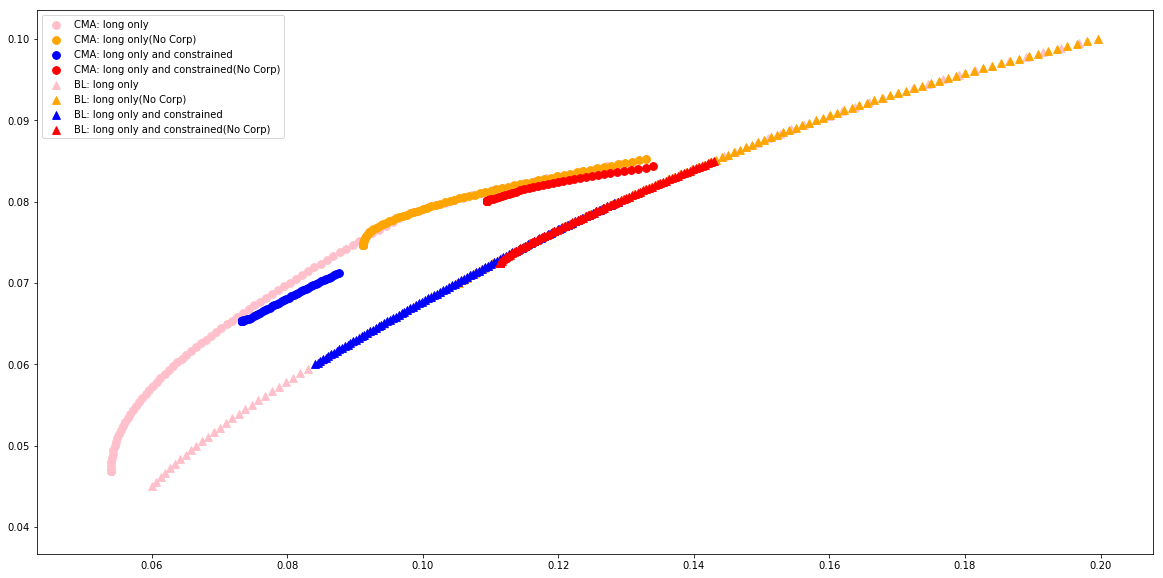

In [17]:
fig= plt.figure(figsize=(20, 10))

plt.scatter(x= [x[1] for x in frontier_uncons_pair], y= [x[0] for x in frontier_uncons_pair], 
            marker='o', c= 'pink', s=60, label= 'CMA: long only')
plt.scatter( x= [x[1] for x in frontier_uncons_NoCorp_pair], y = [x[0] for x in frontier_uncons_NoCorp_pair], 
           marker= 'o', c= 'orange', s=60, label= 'CMA: long only(No Corp)')
plt.scatter(x= [x[1] for x in frontier_cons_pair], y= [x[0] for x in frontier_cons_pair], 
            marker= 'o', c= 'blue' , s=60, label= 'CMA: long only and constrained')
plt.scatter(x= [x[1] for x in frontier_cons_NoCorp_pair], y= [x[0] for x in frontier_cons_NoCorp_pair], 
           marker= 'o', c= 'red', s=60, label= 'CMA: long only and constrained(No Corp)')


frontier_BLuncons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLuncons.values()]
frontier_uncons_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_BLuncons_pair], y= [x[0] for x in frontier_BLuncons_pair], 
            marker='^', c= 'pink', s=60, label= 'BL: long only')

frontier_BLuncons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLuncons_NoCorp.values()]
frontier_BLuncons_NoCorp_pair.sort(key= lambda x : x[0])
plt.scatter( x= [x[1] for x in frontier_BLuncons_NoCorp_pair], y = [x[0] for x in frontier_BLuncons_NoCorp_pair], 
           marker= '^', c= 'orange', s=60, label= 'BL: long only(No Corp)')


frontier_BLcons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLcons.values()]
frontier_BLcons_pair.sort(key= lambda x : x[0])
plt.scatter(x= [x[1] for x in frontier_BLcons_pair], y= [x[0] for x in frontier_BLcons_pair], 
            marker= '^', c= 'blue' , s=60, label= 'BL: long only and constrained')

frontier_BLcons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLcons_NoCorp.values()]
frontier_BLcons_NoCorp_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_BLcons_NoCorp_pair], y= [x[0] for x in frontier_BLcons_NoCorp_pair], 
           marker= '^', c= 'red', s=60, label= 'BL: long only and constrained(No Corp)')
plt.legend()

Note: 
1. CMA results are represented by nodes while the BL results are triangles. BL result shifted down relative to CMA since BL post return is lower than CMA active. 

2. Applying BL slacks the concentration constrain (at 30% level)

3. Applying BL makes US Corp less different from other assets, hence insensitive to the NoCorp Constrain. (Kicking out US Corp leads to smooth extension of the frontier and insignificant jump compared to the CMA cases.)

In [18]:
# For display purpose 


writter= pd.ExcelWriter('output_wz3.xlsx')
tmp_df1= pd.DataFrame(   [[x[0], x[1]]+ x[2].tolist()  for x in frontier_uncons_pair], 
                      columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name']  )
tmp_df2= pd.DataFrame(  [[x[0], x[1]]+ x[2].tolist()  for x in frontier_uncons_NoCorp_pair], 
                     columns=  ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df3= pd.DataFrame(  [[x[0], x[1]]+ x[2].tolist()  for x in frontier_cons_pair], 
                     columns=  ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df4= pd.DataFrame(  [[x[0], x[1]]+ x[2].tolist()  for x in frontier_cons_NoCorp_pair], 
                     columns=  ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df5= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLuncons_pair], 
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df6= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLuncons_NoCorp_pair],
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df7= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLcons_pair], 
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df8= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLcons_NoCorp_pair],
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])


tmp_df1.to_excel( writter, 'UNCONS')
tmp_df2.to_excel( writter, 'UNCONS_NoCorp')
tmp_df3.to_excel( writter, 'CONS')
tmp_df4.to_excel( writter, 'CONS_NoCorp')
tmp_df5.to_excel( writter, 'BL_UNCONS')
tmp_df6.to_excel( writter, 'BL_UNCONS_NoCorp')
tmp_df7.to_excel( writter, 'BL_CONS')
tmp_df8.to_excel( writter,  'BL_CONS_NoCorp')
writter.save()


## Active Management Optimization


Treat Peer as bechmark, max the benefit from deviation with limited tracking error budget. 